![](https://images.aicrowd.com/raw_images/challenges/banner_file/956/7e8d18912839dd712e9c.jpg)

<h2><center> Getting Started with fastai NLP</center></h2>

In this puzzle, we have to classify the programming language from code. For classifying programming language we will have code snippets from which we need to identify the programming language.

In this notebook:
> For tokenization: We will use **TextDataLoaders**.

> For Classification: We will use **text_classifier_learner**.




 AIcrowd code utilities for downloading data for Language Classification


# Download the files 💾¶
## Download AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.

We'll install fastai too.

In [1]:
!pip install aicrowd-cli
# run this, then restart the runtime
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 44 kB 2.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 214 kB 47.4 MB/s 
     |████████████████████████████████| 170 kB 63.8 MB/s 
     |████████████████████████████████| 1.1 MB 48.6 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 51 kB 5.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 22.3.0
    Uninstalling pyzmq-22.3.0:
      Successfully uninstalled pyzmq-22.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you hav

     |████████████████████████████████| 189 kB 8.4 MB/s 
     |████████████████████████████████| 56 kB 5.9 MB/s 



## Login to AIcrowd ㊗¶


In [2]:
%load_ext aicrowd.magic

In [3]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/vZ0VPb2aPSeGoSGQ3DqB7LLw0s-fwMzNAQ1gMERaiXg
API Key valid
Saved API Key successfully!



## Download Dataset¶

We will create a folder name data and download the files there.


In [4]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c programming-language-classification -o data

sample_submission.csv:   0%|          | 0.00/121k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/7.71M [00:00<?, ?B/s]

## Importing Libraries:

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn

from fastai.text.all import *

# TODO: remove unused imports?
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score

from sklearn import set_config
set_config(display="diagram")

plt.rcParams["figure.figsize"] = (15,6)

## Diving in the dataset 🕵️‍♂️

In [6]:
train_df = pd.read_csv("data/train.csv")

In [7]:
test_df = pd.read_csv("data/test.csv")

In [8]:
len(train_df), len(test_df)

(45628, 9277)

# TODO

## look for duplicates (especially in over-rep langs)

## oversample under-rep with ...

- remove leading/trailing whitespace

assume "part"s are separated by line break
- remove 1st n parts
- remove last n parts
- remove n parts at random
- shuffle parts?
- remove dulicated parts

## if we do this &uarr; - we should augment and use TTA

## double/triple
- ruby           1117
- dart           1023
- julia          1005

## 4x?
- php             260
- swift           260
- f-sharp         246
- R               160
- scala           147

In [9]:
def augment_train_df(df, language, n_times):
    lang_df = df[df['language'] == language].copy()
    print(language, 'has', len(lang_df), 'samples')
    if n_times == 0:
        return df

    _df = lang_df.copy() # strip whitespace
    _df['code'] = _df['code'].str.strip()
    df = pd.concat([df, _df])
    if n_times == 1:
        return df
    
    _df = lang_df.copy() # remove 1st part
    def _do(s):
        if '\n' in s:
            return s[s.index('\n')+1:]
        return s
    _df['code'] = _df['code'].apply(_do)
    df = pd.concat([df, _df])
    
    _df = lang_df.copy() # remove last part
    def _do(s):
        if '\n' in s:
            return s[:s.rindex('\n')]
        return s
    _df['code'] = _df['code'].apply(_do)
    df = pd.concat([df, _df])
    
    _df = lang_df.copy() # shuffle parts
    def _do(s):
        if '\n' in s:
            ss = s.split('\n')
            random.shuffle(ss)
            return '\n'.join(ss)
        return s
    _df['code'] = _df['code'].apply(_do)
    df = pd.concat([df, _df])
    
    return df

In [10]:
for language in ['ruby', 'dart', 'julia']:
    train_df = augment_train_df(train_df, language, 1)
for language in ['php', 'swift', 'f-sharp', 'R', 'scala']:
    train_df = augment_train_df(train_df, language, 4)
len(train_df), len(test_df)

ruby has 1117 samples
dart has 1023 samples
julia has 1005 samples
php has 260 samples
swift has 260 samples
f-sharp has 246 samples
R has 160 samples
scala has 147 samples


(53065, 9277)

&darr; reduce the amount of data we're training on to make it quicker to get a trained classifier

**don't** do this for final submission

In [11]:
# train_df["RANK"] = train_df.groupby("language")["id"].rank(method="first", ascending=True)
# train_df = train_df[train_df['RANK']<1000]
# test_df = test_df[::10] # use every 10th row of the training data

In [12]:
# len(train_df), len(test_df)

# Data processing

## replace all numeric literals with special tokens

hope this will make it easier for the model to learn the concept of numbers without having to deal with all of the different actual values

## try to keep important whitespace

whitespace is usually compressed into single spaces when working with natural languages - i think whitespace might have semantic meaning (hopefully predictive power) in code

## replace 2 spaces with a special token

do we want to add some kind of repitition marker - like xxrep?

## replace tabs and linebreaks with special tokens

## LAST STEP: replace any consecutive whitespace with a single space

TODO: check that we now get fastai xxwrep for yy2space etc

In [13]:
def processs_df(df):
    for pat, repl in [
                      [r'(?<!\w)\d+\.\d+(?!\w)', 'yyfloat'], 
                      [r'(?<!\w)\d+(?!\w)', 'yyint'],
                    #   ['    ', ' yy4space '],
                    #   ['   ', ' yy3space '],
                      ['  ', ' yy2space '],
                      ['\t', ' yytab '],
                      ['\n', ' yylinebreak '],
                      ['\s+', ' ']]:
        df['code'] = df['code'].str.replace(pat, repl)
    return df

In [14]:
for df in [train_df, test_df]:
    processs_df(df)

In [15]:
    train_df[train_df['code'].str.contains('yyfloat')]

id  ... language
55     19346  ...     dart
57     29910  ...    julia
84     59289  ...    julia
109    22771  ...    julia
114    25043  ...    julia
...      ...  ...      ...
30222  68414  ...        R
33417  41713  ...        R
38685  14539  ...        R
42737  17430  ...        R
45400  32375  ...        R

[2362 rows x 3 columns]

# Quick fastai lstm classifier

https://github.com/fastai/fastai/blob/master/nbs/38_tutorial.text.ipynb

```
TextDataLoaders.from_df(
    df, path='.', valid_pct=0.2, seed=None, text_col=0, label_col=1, 
    label_delim=None, y_block=None, text_vocab=None, is_lm=False, 
    valid_col=None, tok_tfm=None, tok_text_col='text', seq_len=72, 
    backwards=False, bs=64, val_bs=None, shuffle=True, device=None)
```

## language model

Start by training a language model - the pre-trained model (trained on wikipedia text) doesn't know much about code ...

Notes;
- to give us as much code to learn from as possible
    - we combine unlabelled test data with training data 
    - we use a low valid percent
        - TODO: explain why this is ok for LM training

TODO:
- add some logic to preserve white space semantics

In [16]:
lm_df = pd.concat([train_df[['code']], test_df[['code']]])

In [17]:
len(train_df), len(test_df), len(lm_df)

(53065, 9277, 62342)

In [18]:
dls_lm = TextDataLoaders.from_df(lm_df, text_col='code', is_lm=True, valid_pct=0.1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [19]:
dls_lm.show_batch()

In [20]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

Note: we use the training "protocol" from the text tutorial, running `lr_find` just fyi

SuggestedLRs(valley=0.0063095735386013985)

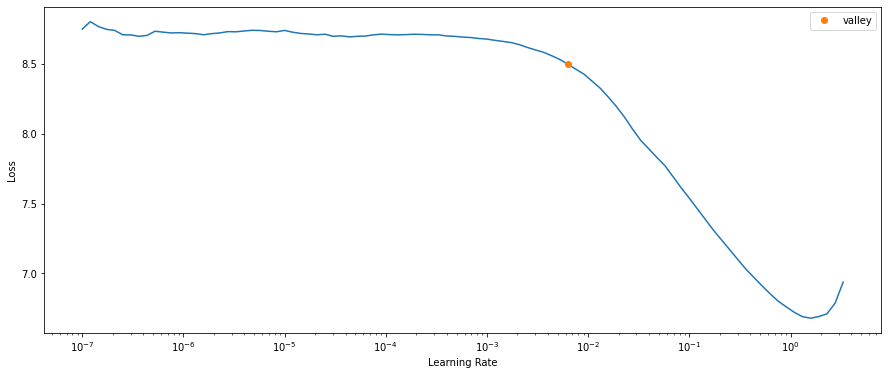

In [21]:
learn_lm.lr_find()

In [22]:
learn_lm.fit_one_cycle(1, 1e-2)

In [23]:
learn_lm.save('lm_1epoch')

Path('models/lm_1epoch.pth')

SuggestedLRs(valley=0.0003981071640737355)

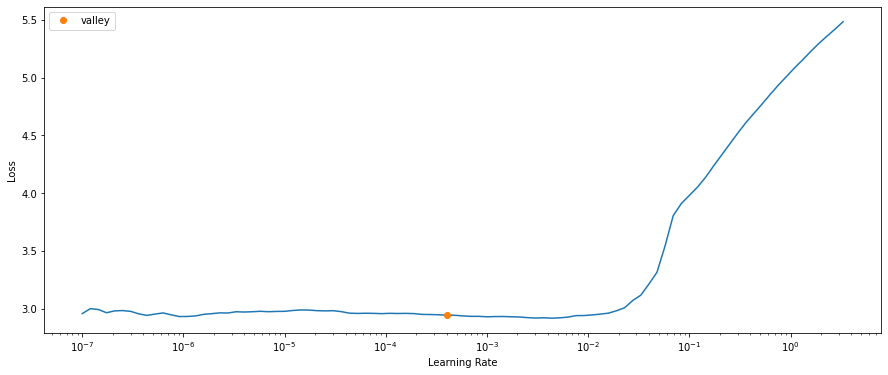

In [24]:
learn_lm = learn_lm.load('lm_1epoch')
learn_lm.unfreeze()
learn_lm.lr_find()

Note: we use `SaveModelCallback` in case we train for too many epochs (not great with one-cycle but better than getting stuck with an over-cooked model) - this might save us having to re-train from "lm_1epoch"

In [25]:
learn_lm = learn_lm.load('lm_1epoch')
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 1e-3, cbs=SaveModelCallback(fname='lm_best_model'))

Better model found at epoch 0 with valid_loss value: 2.079366683959961.
Better model found at epoch 1 with valid_loss value: 1.7836370468139648.
Better model found at epoch 2 with valid_loss value: 1.6462273597717285.
Better model found at epoch 3 with valid_loss value: 1.5787004232406616.
Better model found at epoch 4 with valid_loss value: 1.5643589496612549.


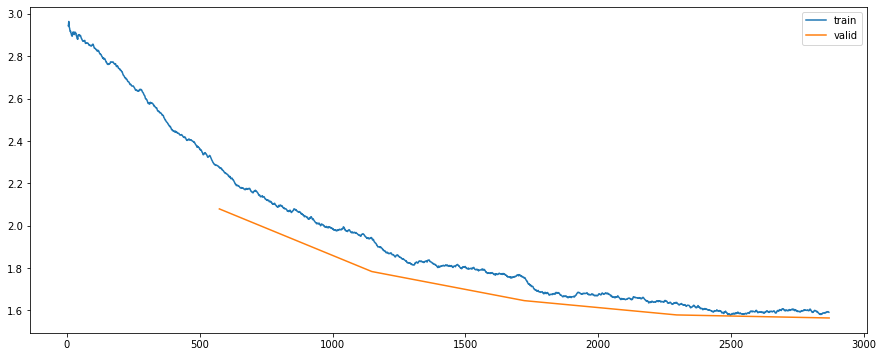

In [26]:
learn_lm.recorder.plot_loss()

In [27]:
learn_lm.save('lm_finetuned')
learn_lm.save_encoder('lm_encoder_finetuned')
torch.save(dls_lm, 'models/lm_dls.pkl')

using just the training data and a default valid_pct `learn_lm.fine_tune(4, 1e-2)` gave us

<div id="output-body"><div class="display_data output-id-356"><div class="output_subarea output_html rendered_html"><table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th>epoch</th>
      <th>train_loss</th>
      <th>valid_loss</th>
      <th>accuracy</th>
      <th>perplexity</th>
      <th>time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>4.127742</td>
      <td>3.569793</td>
      <td>0.337202</td>
      <td>35.509224</td>
      <td>04:24</td>
    </tr>
  </tbody>
</table></div></div><div class="display_data output-id-1774"><div class="output_subarea output_html rendered_html"><table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th>epoch</th>
      <th>train_loss</th>
      <th>valid_loss</th>
      <th>accuracy</th>
      <th>perplexity</th>
      <th>time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>3.252794</td>
      <td>2.976321</td>
      <td>0.425069</td>
      <td>19.615513</td>
      <td>05:02</td>
    </tr>
    <tr>
      <td>1</td>
      <td>2.826681</td>
      <td>2.602097</td>
      <td>0.480698</td>
      <td>13.492004</td>
      <td>05:08</td>
    </tr>
    <tr>
      <td>2</td>
      <td>2.573639</td>
      <td>2.458117</td>
      <td>0.500367</td>
      <td>11.682790</td>
      <td>05:10</td>
    </tr>
    <tr>
      <td>3</td>
      <td>2.453192</td>
      <td>2.424428</td>
      <td>0.506975</td>
      <td>11.295764</td>
      <td>05:04</td>
    </tr>
  </tbody>
</table></div></div></div>

## classifier

calculate class weights with 

`n_samples / (n_classes * np.bincount(y))`

see: https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [28]:
n_samples = len(train_df)
classes = sorted(train_df['language'].unique())
n_classes = len(classes)
class_weight_map = {}
for language, bincount in train_df['language'].value_counts().iteritems():
    class_weight_map[language] = n_samples / (n_classes * bincount)
class_weights = tensor([class_weight_map[c] for c in classes]).cuda()
print(classes)
print(class_weights)

['R', 'c', 'c-plus-plus', 'c-sharp', 'dart', 'f-sharp', 'go', 'java', 'javascript', 'julia', 'php', 'python', 'ruby', 'scala', 'swift']
tensor([4.4221, 0.7750, 0.3137, 0.9094, 1.7291, 2.8762, 1.7858, 0.8193, 1.3098,
        1.7600, 2.7213, 0.2790, 1.5836, 4.8132, 2.7213], device='cuda:0')


In [29]:
dls_clas = TextDataLoaders.from_df(train_df, text_col='code', label_col='language', text_vocab=dls_lm.vocab) # TODO: valid_col for stratified/repeateable split

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [30]:
dls_clas.show_batch()

In [31]:
# NOT: using FocalLossFlat(weight=class_weights)
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy], loss_func=FocalLossFlat(), wd=1e-2)

In [32]:
learn_clas.loss_func

FlattenedLoss of FocalLoss()

In [33]:
learn_clas = learn_clas.load_encoder('lm_encoder_finetuned')

SuggestedLRs(valley=0.0014454397605732083)

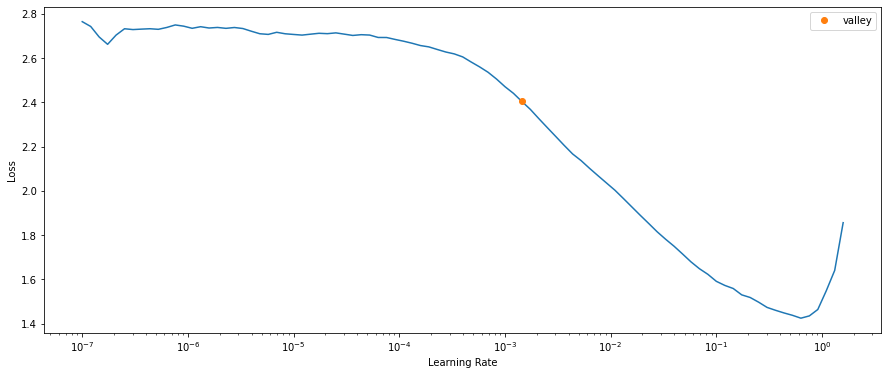

In [34]:
learn_clas.lr_find()

In [35]:
learn_clas.fit_one_cycle(1, 2e-2)

In [36]:
learn_clas.save('clas_step1')

Path('models/clas_step1.pth')

In [37]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [38]:
learn_clas.save('clas_step2')

Path('models/clas_step2.pth')

In [39]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

In [58]:
learn_clas.save('clas_step3')

Path('models/clas_step3.pth')

In [131]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

- **label**
    - **final after unfreeze**
    - **leader board**
- full dataset
    - 0.888329
    - 0.785
- baseline (small dataset)
    - 0.490387	0.492859	0.822333	
    - 0.678
- yyint
    - 0.530182	0.499005	0.813743
- yyfloat and yyint
    - 0.476658	0.544016	0.810579
    - 0.685
- yyfloat and yyint and whitespace
    - 0.411087	0.378865	0.860759	
    - 0.849
- yyfloat and yyint and whitespace (weighted focal loss)
    - 0.243585	0.270471	0.825045
    - 0.814
- full dataset with under-rep aug: yyfloat and yyint and whitespace (focal loss)
    -


In [132]:
learn_clas.save('clas_step4_finetuned')
torch.save(dls_clas, 'models/clas_dls.pkl')

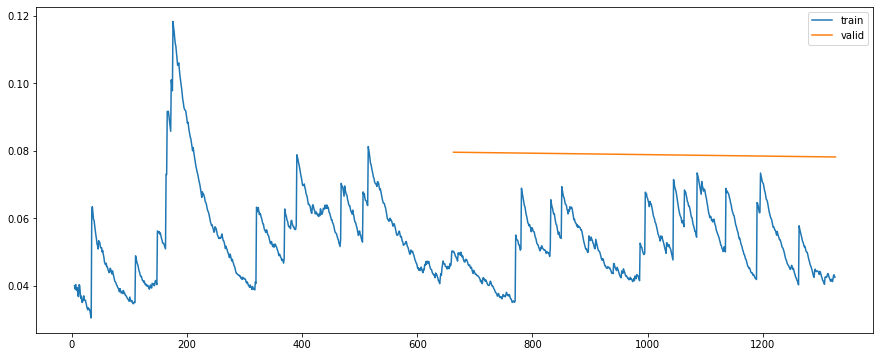

In [133]:
learn_clas.recorder.plot_loss()

# Prediction Phase ✈

In [134]:
test_df = processs_df(pd.read_csv("data/test.csv"))
test_df.shape, test_df.columns

((9277, 2), Index(['id', 'code'], dtype='object'))

In [135]:
test_df.iloc[1]['code']

' yy2space yy2space yy2space this.path = path; yylinebreak yylinebreak yy2space yy2space yy2space this.estimated = estimated; yylinebreak yylinebreak yy2space yy2space } yylinebreak yylinebreak yy2space yy2space public int getDistance() { yylinebreak yylinebreak yy2space yy2space yy2space return distance; yylinebreak yylinebreak yy2space yy2space } yylinebreak '

In [136]:
learn_clas.predict(test_df.iloc[1]['code'])[0]

'java'

In [137]:
test_dl = learn_clas.dls.test_dl(test_df['code'])

In [138]:
preds_with_decoded = learn_clas.get_preds(dl=test_dl, with_decoded=True)

In [139]:
preds_with_decoded[2]

TensorText([11,  7,  3,  ...,  3,  2,  7])

In [140]:
labels = dls_clas.vocab[1] # sorted(train_df['language'].unique())

In [141]:
target = preds_with_decoded[2].detach().cpu().numpy()
target

array([11,  7,  3, ...,  3,  2,  7])

In [142]:
test_df['target'] = target
test_df.head()

id  ... target
0  10684  ...     11
1  17536  ...      7
2  26383  ...      3
3  29090  ...      8
4  10482  ...      2

[5 rows x 3 columns]

In [143]:
prediction = [labels[t] for t in target]

In [144]:
test_df["prediction"] = prediction
test_df.head()

id  ...   prediction
0  10684  ...       python
1  17536  ...         java
2  26383  ...      c-sharp
3  29090  ...   javascript
4  10482  ...  c-plus-plus

[5 rows x 4 columns]

In [145]:
pd.concat([test_df, pd.read_csv("data/test.csv")], axis='columns').to_csv('submission2.csv', index=False)

## Generating Prediction File

In [146]:
# TODO: why would we sample test_df?? <- this just shuffles the data - so why do we want to shuffle?
# test_df = test_df.sample(frac=1)
# test_df.head()

In [ ]:
!rm -rf assets
!mkdir assets
test_df.to_csv(os.path.join("assets", "submission.csv"))


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [ ]:
%aicrowd notebook submit -c programming-language-classification -a assets --no-verify